In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# data will come from a known distribution
# so we can check our answer
def generate_batch(batch_size=32):
    # x in (-5, +5)
    x = np.random.random(batch_size)*10 - 5
    
    # sd is a function of x
    sd = 0.05 + 0.1*(x + 5)
    
    # target = mean + noise * sd
    y = np.cos(x) - 0.3 * x + np.random.randn(batch_size) * sd
    
    return x, y

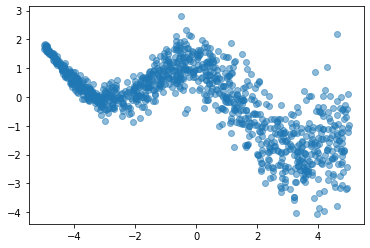

In [3]:
# visualize the data
x, y = generate_batch(1024)
plt.scatter(x, y, alpha = 0.5)

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.ann1 = nn.Sequential(
            nn.Linear(1,10),
            nn.Tanh(),
            nn.Linear(10,1),
        )
        
        self.ann2 = nn.Sequential(
            nn.Linear(1,10),
            nn.Tanh(),
            nn.Linear(10,1),
        )
        
    def forward(self, inputs):
        # returns (mean, log-variance)
        return self.ann1(inputs), self.ann2(inputs)

In [5]:
model = Model()

In [6]:
def criterion(outputs, targets):
    mu = outputs[0]
    v = torch.exp(outputs[-1])
    
    # coefficient term
    c = torch.log(torch.sqrt(2 *np.pi*v))
    
    # exponent term
    f = 0.5 / v * (targets - mu)**2
    
    # mean log-likelihood
    nll = torch.mean(c + f)
    
    return nll

In [7]:
optimizer = torch.optim.Adam(model.parameters())

In [9]:
epochs = 5000
batch_size = 128
losses = np.zeros(epochs)

for it in range(epochs):
    x, y = generate_batch(batch_size)
    
    # convert to torch tensor
    inputs = torch.from_numpy(x).float()
    targets = torch.from_numpy(y).float()
    
    # reshape the data
    inputs, targets = inputs.view(-1,1), targets.view(-1,1)
    
    # zero grad
    optimizer.zero_grad()
    
    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # store losses
    losses[it] = loss.item()
    
    # print loss
    if it % 1000 == 0:
        print( it, losses[it])
        
    # optimize
    loss.backward()
    optimizer.step()

0 1.6836497783660889
1000 0.9163033366203308
2000 0.67625492811203
3000 0.7660291790962219
4000 0.563223123550415


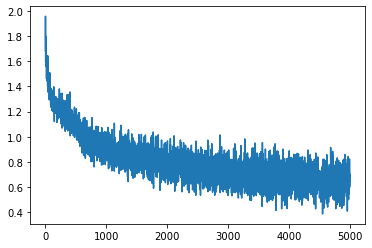

In [10]:
plt.plot(losses)

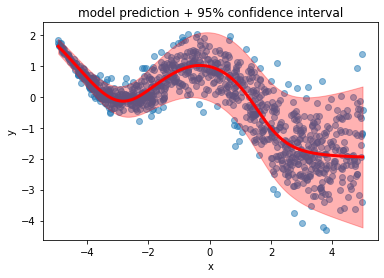

In [14]:
# plot the model predictions
x, y = generate_batch(1024)
plt.scatter(x,y, alpha=0.5)

# convert to torch tensor
inputs = torch.from_numpy(x).float()
targets = torch.from_numpy(y).float()

# reshape data
inputs, targets = inputs.view(-1,1), targets.view(-1,1)

with torch.no_grad():
    outputs = model(inputs)
    yhat = outputs[0].numpy().flatten()
    sd = np.exp(outputs[1].numpy().flatten() / 2 )
    
idx = np.argsort(x)
plt.plot( x[idx], yhat[idx], linewidth=3, color='red')
plt.fill_between( x[idx], yhat[idx] - 1.96*sd[idx], yhat[idx] + 1.96*sd[idx], color = 'red', alpha=0.3 )
plt.xlabel('x')
plt.ylabel('y')
plt.title('model prediction + 95% confidence interval')
plt.show()